In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import skvideo.io
import io
import base64
from IPython.display import HTML

sns.set()
plt.rcParams["figure.figsize"] = fig_size = (12, 8)
plt.rcParams["axes.titlesize"] = 'x-large'

# Data

In [2]:
# make data
x = np.array(range(-10,10))*np.pi/2
y = 5*np.sin(x/5)
eps_homo = np.random.normal(y)
eps_hetero = np.random.normal(y) * np.abs(y)
y_homo = y + eps_homo
y_hetero = y + eps_hetero

In [3]:
x_miss = np.concatenate((x[:13],x[18:]))
y_homo_miss = np.concatenate((y_homo[:13],y_homo[18:]))

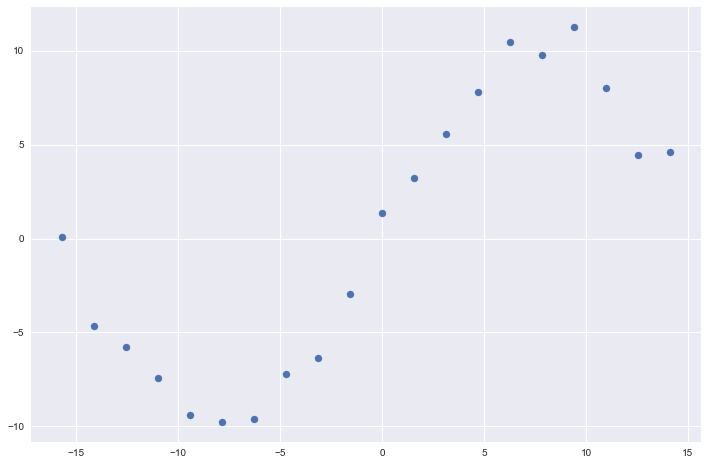

In [4]:
# Homoscedastic aleatoric error
plt.scatter(x,y_homo, s=50)
plt.show()

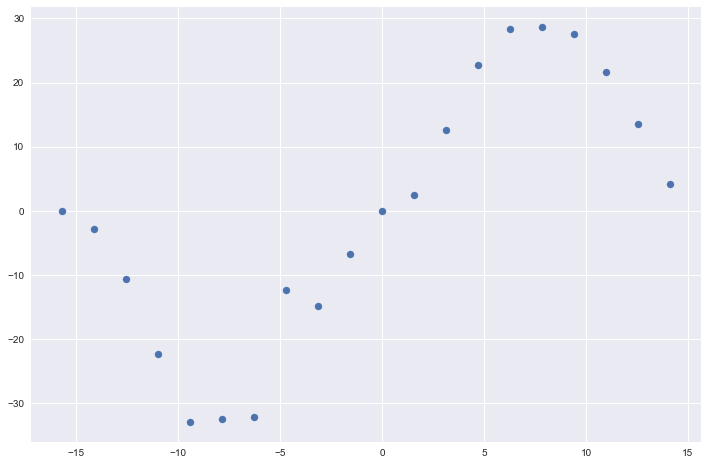

In [5]:
# Heteroscedastic aleatoric error
plt.scatter(x,y_hetero, s=50)
plt.show()

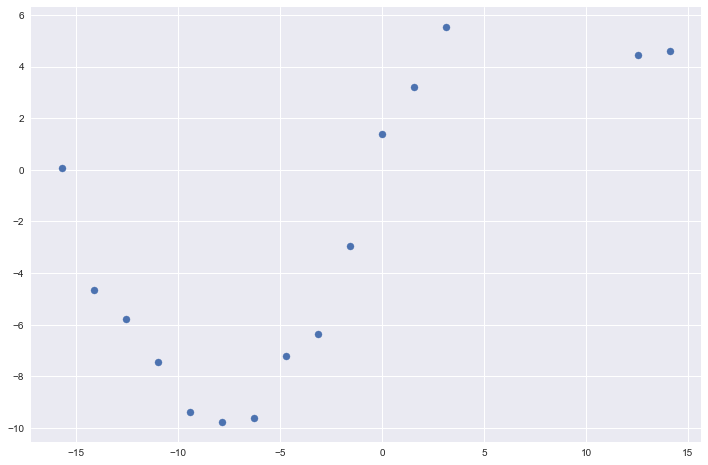

In [6]:
# Homoscedastic aleatoric error
plt.scatter(x_miss,y_homo_miss, s=50)
plt.show()

In [7]:
class GaussianDropout(nn.Module):
    def __init__(self, p=1.0):
        super().__init__()
        self.alpha = torch.Tensor([np.sqrt(p/(1-p))])
        
    def forward(self, x):
        """
        Sample noise   e ~ N(1, alpha)
        Multiply noise h = h_ * e
        """
        if self.train():
            # N(1, alpha)
            epsilon = torch.randn(x.size()) * self.alpha + 1

            epsilon = Variable(epsilon)
            if x.is_cuda:
                epsilon = epsilon.cuda()

            return x * epsilon
        else:
            return x

In [8]:
class VariationalDropout(nn.Module):
    def __init__(self, alpha=1.0, dim=None):
        super().__init__()
        self.dim = dim
        self.max_alpha = alpha
        # Initial alpha
        log_alpha = (torch.ones(dim) * alpha).log()
        self.log_alpha = nn.Parameter(log_alpha)
        
    def kl(self):
        c1 = 1.16145124
        c2 = -1.50204118
        c3 = 0.58629921
        
        alpha = self.log_alpha.exp()
        
        negative_kl = 0.5 * self.log_alpha + c1 * alpha + c2 * alpha**2 + c3 * alpha**3
        
        kl = -negative_kl
        
        return kl.mean()
    
    def forward(self, x):
        """
        Sample noise   e ~ N(1, alpha)
        Multiply noise h = h_ * e
        """
        if self.train():
            # N(0,1)
            epsilon = Variable(torch.randn(x.size()))
            if x.is_cuda:
                epsilon = epsilon.cuda()

            # Clip alpha
            self.log_alpha.data = torch.clamp(self.log_alpha.data, max=self.max_alpha)
            alpha = self.log_alpha.exp()

            # N(1, alpha)
            epsilon = epsilon * alpha

            return x * epsilon
        else:
            return x

In [9]:
def dropout(p=None, dim=None, method='standard'):
    if method == 'standard':
        return nn.Dropout(p)
    elif method == 'gaussian':
        return GaussianDropout(p)
    elif method == 'variational':
        return VariationalDropout(p, dim)

# Network

In [10]:
class Net(nn.Module):
    def __init__(self, hidden_size=20, dropout_method='gaussian'):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc1.weight.data.normal_(0, 0.1)   # initialization
        self.drop1 = dropout(0.1, hidden_size, dropout_method)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc2.weight.data.normal_(0, 0.1)   # initialization
        self.drop2 = dropout(0.1, hidden_size, dropout_method)
        self.out = nn.Linear(hidden_size, 1)
        self.out.weight.data.normal_(0, 0.1)   # initialization
        
    def forward(self, x, training):
        x = F.relu(self.drop1(self.fc1(x)))
        x = F.relu(self.drop2(self.fc2(x)))
        out = self.out(x)
            
        return out

In [11]:
video_path = './result_standard.mp4'
writer = skvideo.io.FFmpegWriter(video_path)

# Homoscedastic data fitting with only MC dropout
MCD_net = Net(dropout_method='standard')
MCD_opt = torch.optim.Adam(MCD_net.parameters(),lr=1e-4)
MCD_loss_func = nn.MSELoss(reduce=False)
    
for _ in range(5*10**4):
    # Sample the data with replacement
    index = np.random.choice(range(len(x_miss)),size = 2**4)
    x_chosen = Variable(torch.FloatTensor(x_miss[index]).view(-1,1))
    y_chosen = Variable(torch.FloatTensor(y_homo_miss[index]).view(-1,1))
    
    # Prdict and calculate the loss
    y_predict = MCD_net.forward(x_chosen, training = True)
    loss = MCD_loss_func(y_predict, y_chosen).mean()
    
    MCD_opt.zero_grad()
    loss.backward()
    MCD_opt.step()
    
    if (_%10**2) == 0:
        x_test = np.array(range(-40,40))/2.*np.pi
        x_chosen = Variable(torch.FloatTensor(x_test).view(-1,1))
        y_pred = np.zeros((100, 80,1))
        y_uncert = np.zeros((100, 80,1))

        for i in range(100):
            y_predict= MCD_net.forward(x_chosen, training = True)
            y_pred[i] = y_predict.cpu().data

        y_pred_mean = y_pred.mean(axis = 0)
        y_pred_std = y_pred.std(axis = 0)
        
        # make figure
        fig = plt.figure()
        plt.scatter(x_miss,y_homo_miss, s=50)
        plt.plot(x_test, y_pred_mean)
        plt.fill_between(x_test, y_pred_mean.reshape(-1) - y_pred_std.reshape(-1), 
                         y_pred_mean.reshape(-1) + y_pred_std.reshape(-1),color='gray', alpha=0.5)
        plt.fill_between(x_test, y_pred_mean.reshape(-1) - 2*y_pred_std.reshape(-1), 
                         y_pred_mean.reshape(-1) + 2*y_pred_std.reshape(-1),color='gray', alpha=0.3)
    
        plt.xlim(-60,60)
        plt.ylim(-20,20)
        plt.title(str(_)+' th loss :'+ str(loss.cpu().item()))
        fig.canvas.draw()

        # Get the RGBA buffer from the figure
        w,h = fig.canvas.get_width_height()
        buf = np.fromstring(fig.canvas.tostring_argb(), dtype=np.uint8)
        buf.shape = (h, w, 4)
        plot = buf[:, :, 1:]
        plt.close()
        outputframe = np.zeros((h, w, 3))
        outputframe[:, :] = plot
        writer.writeFrame(outputframe)

writer.close()

video = io.open('./result_standard.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

/Users/SungYub/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:52: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [12]:
video_path = './result_gaussian.mp4'
writer = skvideo.io.FFmpegWriter(video_path)

# Homoscedastic data fitting with only MC dropout
MCD_net = Net(dropout_method='gaussian')
MCD_opt = torch.optim.Adam(MCD_net.parameters(),lr=1e-4)
MCD_loss_func = nn.MSELoss(reduce=False)
    
for _ in range(5*10**4):
    # Sample the data with replacement
    index = np.random.choice(range(len(x_miss)),size = 2**4)
    x_chosen = Variable(torch.FloatTensor(x_miss[index]).view(-1,1))
    y_chosen = Variable(torch.FloatTensor(y_homo_miss[index]).view(-1,1))
    
    # Prdict and calculate the loss
    y_predict = MCD_net.forward(x_chosen, training = True)
    loss = MCD_loss_func(y_predict, y_chosen).mean()
    
    MCD_opt.zero_grad()
    loss.backward()
    MCD_opt.step()
    
    if (_%10**2) == 0:
        x_test = np.array(range(-40,40))/2.*np.pi
        x_chosen = Variable(torch.FloatTensor(x_test).view(-1,1))
        y_pred = np.zeros((100, 80,1))
        y_uncert = np.zeros((100, 80,1))

        for i in range(100):
            y_predict= MCD_net.forward(x_chosen, training = True)
            y_pred[i] = y_predict.cpu().data

        y_pred_mean = y_pred.mean(axis = 0)
        y_pred_std = y_pred.std(axis = 0)
        
        # make figure
        fig = plt.figure()
        plt.scatter(x_miss,y_homo_miss, s=50)
        plt.plot(x_test, y_pred_mean)
        plt.fill_between(x_test, y_pred_mean.reshape(-1) - y_pred_std.reshape(-1), 
                         y_pred_mean.reshape(-1) + y_pred_std.reshape(-1),color='gray', alpha=0.5)
        plt.fill_between(x_test, y_pred_mean.reshape(-1) - 2*y_pred_std.reshape(-1), 
                         y_pred_mean.reshape(-1) + 2*y_pred_std.reshape(-1),color='gray', alpha=0.3)
    
        plt.xlim(-60,60)
        plt.ylim(-20,20)
        plt.title(str(_)+' th loss :'+ str(loss.cpu().item()))
        fig.canvas.draw()

        # Get the RGBA buffer from the figure
        w,h = fig.canvas.get_width_height()
        buf = np.fromstring(fig.canvas.tostring_argb(), dtype=np.uint8)
        buf.shape = (h, w, 4)
        plot = buf[:, :, 1:]
        plt.close()
        outputframe = np.zeros((h, w, 3))
        outputframe[:, :] = plot
        writer.writeFrame(outputframe)

writer.close()

video = io.open('./result_gaussian.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

/Users/SungYub/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:52: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
